In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import cumulative_trapezoid, cumulative_simpson
import scipy.optimize as optimize

import src.astrocal.cpi as cpi

In [3]:
main = "C:/Users/aurel/Desktop/DUAO Projet/(6) Hebe"

In [4]:
data_files = glob.glob(f"{main}/*.csv")
datas = {"_".join(file.split("\\")[-1].split(".")[0].split("_")[1:]): pd.read_csv(file) for file in data_files}
names = list(datas.keys())
print(names)

['20240531_gp', '20240531_ip', '20240531_rp', '20240605_gp', '20240605_ip', '20240605_rp']


In [5]:
print(datas[names[0]].keys())

Index(['Label', 'slice', 'Saturated', 'J.D.-2400000', 'JD_UTC', 'JD_SOBS',
       'JD_MOBS', 'HJD_MOBS', 'BJD_MOBS', 'ALT_OBJ',
       ...
       'N_Src_Pixels_C6', 'N_Sky_Pixels_C6', 'N_Src_Pixels_C7',
       'N_Sky_Pixels_C7', 'N_Src_Pixels_C8', 'N_Sky_Pixels_C8',
       'N_Src_Pixels_C9', 'N_Sky_Pixels_C9', 'N_Src_Pixels_C10',
       'N_Sky_Pixels_C10'],
      dtype='object', length=257)


In [43]:
phase = 7.2745
JD_0 = 0.595 #0.08
for name in names:
    data = datas[name]
    data['phase'] = ((data['JD_UTC']-JD_0)*(24/phase)*360)%360
    offset = -0.02 if "20240605" in name else 0
    data['normalized'] = data['rel_flux_T1']/np.mean(data['rel_flux_T1']) + offset

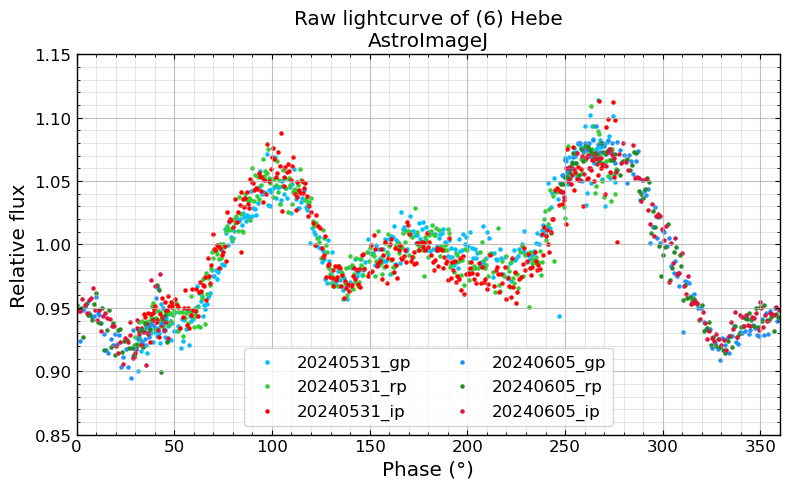

In [54]:
colors = {'20240531_gp': 'deepskyblue',
         '20240531_rp': 'limegreen',
         '20240531_ip': 'red',
         '20240605_gp': 'dodgerblue',
         '20240605_rp': 'forestgreen',
         '20240605_ip': 'crimson',}

fig, ax = plt.subplots(figsize=(8,5))
for name in colors:
    data = datas[name]
    ax.scatter(data['phase'], data['normalized'], color=colors[name], s=5, label=name, rasterized=True)
ax.set_xlim(0,360)
ax.set_ylim(0.85,1.15)
ax.legend(loc='lower center', ncols=2)
ax.set_xlabel("Phase (°)")
ax.set_ylabel("Relative flux")
ax.set_title("Raw lightcurve of (6) Hebe\nAstroImageJ")
ax.grid(True, which='major', alpha=0.8)
ax.grid(True, which='minor', alpha=0.3)
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve_AIJ.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve_AIJ.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

In [51]:
phase = np.arange(0,360,1)
window = 20
analysed_data = {}
for filter in ['gp', 'rp', 'ip']:
    tables = [datas[name][['phase', 'normalized']] for name in names if filter in name]
    concat = pd.concat(tables)
    points = []
    for p in phase:
        start, end = p-0.5*window, p+0.5*window
        if (start<0) & (end>360):
            mean = np.average(concat['normalized'])
        elif start<0:
            mean = np.average(concat['normalized'][(concat['phase']>=start%360)|(concat['phase']<end)])
        elif end>360:
            mean = np.average(concat['normalized'][(concat['phase']>=start)|(concat['phase']<end%360)])
        else:
            mean = np.average(concat['normalized'][(concat['phase']>=start)&(concat['phase']<end)])
        points.append(mean)
    analysed_data[filter] = pd.DataFrame(np.array([phase, points]).T, columns=['phase', 'normalized_avg'])
    
for filter in analysed_data:
    print(f"{filter} : {len(analysed_data[filter])}")

gp : 360
rp : 360
ip : 360


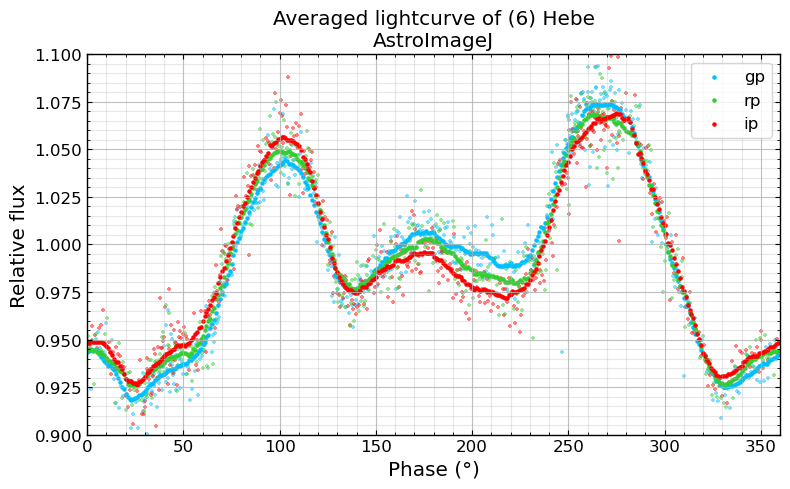

In [60]:
colors = {'gp': 'deepskyblue',
         'rp': 'limegreen',
         'ip': 'red',}
fig, ax = plt.subplots(figsize=(8,5))
for name in datas:
    data = datas[name]
    filter = name.split("_")[-1]
    ax.scatter(data['phase'], data['normalized'], color=colors[filter], marker='+', s=10, alpha=0.5, rasterized=True)
for filter in analysed_data:
    data = analysed_data[filter]
    ax.scatter(data['phase'], data['normalized_avg'], color=colors[filter], s=5, label=filter, rasterized=True)
ax.set_xlim(0,360)
ax.set_ylim(0.9,1.10)
ax.legend(loc='upper right')
ax.set_xlabel("Phase (°)")
ax.set_ylabel("Relative flux")
ax.set_title("Averaged lightcurve of (6) Hebe\nAstroImageJ")
ax.grid(True, which='major', alpha=0.8)
ax.grid(True, which='minor', alpha=0.3)
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve-avg_AIJ.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Lightcurve-avg_AIJ.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

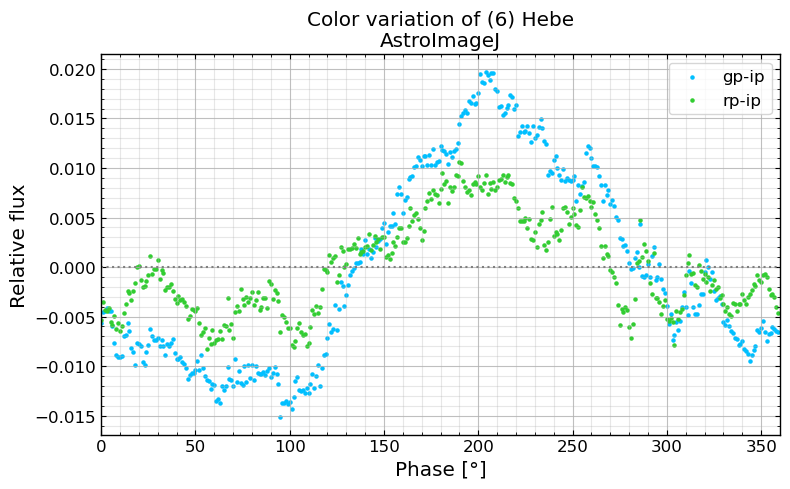

In [53]:
colors = {'gp': 'deepskyblue',
         'rp': 'limegreen',
         'ip': 'red',}
ref = 'ip'
fig, ax = plt.subplots(figsize=(8,5))
for filter in analysed_data:
    if filter != ref:
        data = analysed_data[filter]
        ax.scatter(data['phase'], data['normalized_avg']-analysed_data[ref]['normalized_avg'], color=colors[filter], s=5, label=f"{filter}-{ref}", rasterized=True)
ax.axhline(0, c='gray', ls=':')
ax.set_xlim(0,360)
ax.set_xlabel("Phase [°]")
ax.set_ylabel("Relative flux")
ax.legend()
ax.set_title("Color variation of (6) Hebe\nAstroImageJ")
ax.grid(True, which='major', alpha=0.8)
ax.grid(True, which='minor', alpha=0.3)
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Color_AIJ.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Color_AIJ.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

In [33]:
sun_angle = np.deg2rad(17)
psi = np.pi - sun_angle
# theta, r_gp = cpi.light_curve2radius(analysed_data['gp']['normalized_avg'], sun_angle=sun_angle, harmonics=100)
# theta, r_rp = cpi.light_curve2radius(analysed_data['rp']['normalized_avg'], sun_angle=sun_angle, harmonics=100)
# theta, r_ip = cpi.light_curve2radius(analysed_data['ip']['normalized_avg'], sun_angle=sun_angle, harmonics=100)
theta, r_gp = cpi.light_curve2radius_cons(analysed_data['gp']['normalized_avg'], sun_angle=sun_angle, harmonics=50, normalize=True)
theta, r_rp = cpi.light_curve2radius_cons(analysed_data['rp']['normalized_avg'], sun_angle=sun_angle, harmonics=50, normalize=True)
theta, r_ip = cpi.light_curve2radius_cons(analysed_data['ip']['normalized_avg'], sun_angle=sun_angle, harmonics=50, normalize=True)

C:\Users\aurel\AppData\Local\Temp\ipykernel_18240\1016556422.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


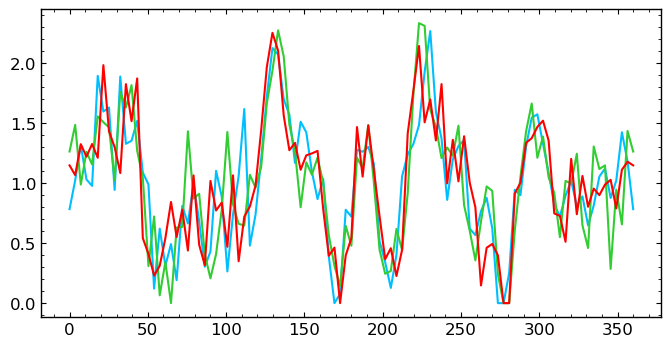

In [34]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.rad2deg(theta), r_gp, color='deepskyblue')
ax.plot(np.rad2deg(theta), r_rp, color='limegreen')
ax.plot(np.rad2deg(theta), r_ip, color='red')
fig.show()

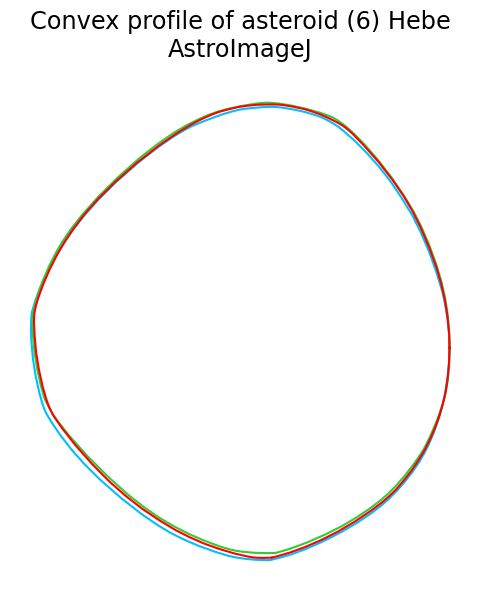

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle("Convex profile of asteroid (6) Hebe\nAstroImageJ")
cpi.plot_from_radius(r_gp, ax=ax, color='deepskyblue')
cpi.plot_from_radius(r_rp, ax=ax, color='limegreen')
cpi.plot_from_radius(r_ip, ax=ax, color='red')
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Convex-profile_AIJ.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Convex-profile_AIJ.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_18240\2767768437.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


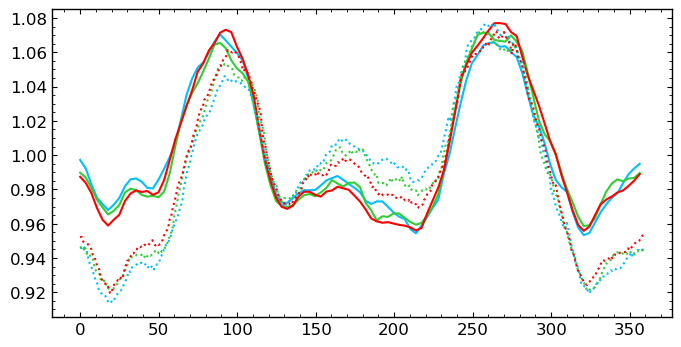

In [36]:
theta, I_gp = cpi.radius2light_curve(r_gp, sun_angle=sun_angle)
theta, I_rp = cpi.radius2light_curve(r_rp, sun_angle=sun_angle)
theta, I_ip = cpi.radius2light_curve(r_ip, sun_angle=sun_angle)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.rad2deg(theta), I_gp, color='deepskyblue')
ax.plot(np.rad2deg(theta), I_rp, color='limegreen')
ax.plot(np.rad2deg(theta), I_ip, color='red')
ax.plot(analysed_data['gp']['phase'], analysed_data['gp']['normalized_avg'], color='deepskyblue', ls=':')
ax.plot(analysed_data['rp']['phase'], analysed_data['rp']['normalized_avg'], color='limegreen', ls=':')
ax.plot(analysed_data['ip']['phase'], analysed_data['ip']['normalized_avg'], color='red', ls=':')
fig.show()